In [1]:
import pandas as pd 

FILE = '../Data/all_data.csv'
df = pd.DataFrame.from_csv(FILE)
df.content = df.content.str.replace('/',' ') 
df.content = df.content.str.replace(',',' ') 
df.content = df.content.str.replace('(',' ')
df.content = df.content.str.replace(')',' ') 
df.content = df.content.str.replace('"','\'') 

C:\Users\Prime\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


In [2]:
df.category = df.category.str.lower()

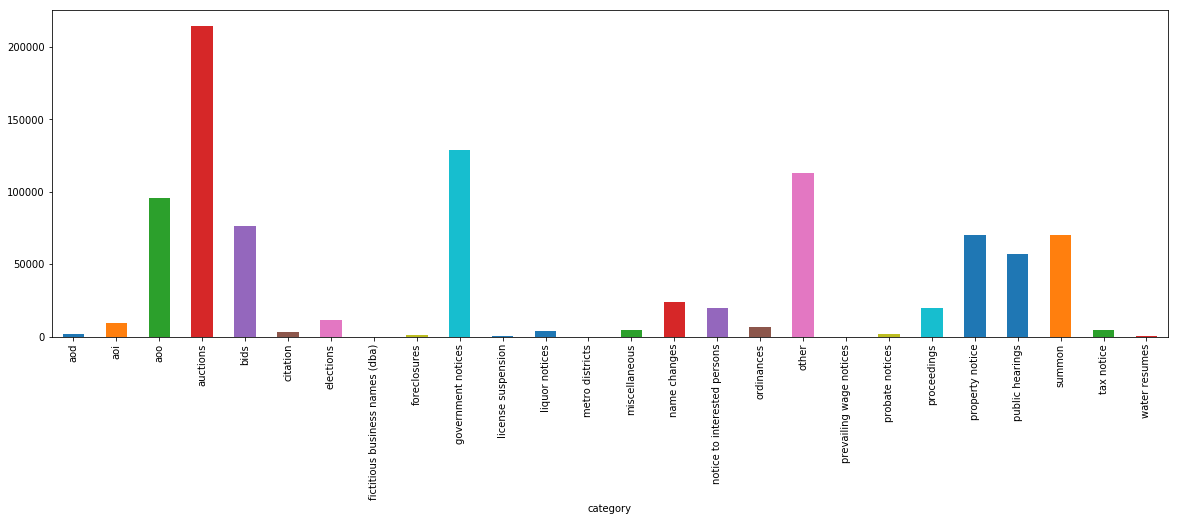

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,6))
df.groupby('category')['content'].count().plot.bar(ylim=0)
plt.show()

In [11]:
len(df)

937046

In [12]:
df = df[df.category=='auctions']

In [13]:
len(df)

214512

In [22]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 

stop_words = set(stopwords.words('english'))

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [15]:
df.content = df.content.astype(str)
# Convert to list
data = df.content.values.tolist()

In [16]:
data[:2]

['notice of auction  on friday  march 17  2017 at 9am  we will be holding an auction on the following abandoned wrecked vehicle:  1984 oldsmobile 88  vin#  1g3bn69y3fy328464  road assist 24  3066 hwy 43 s.  picayune  ms 39466  publish: 2 24 17  3 03 17 and 3 10 17',
 "sheriff's sales bank of america na vs. katedra g. sanchez  #17-0011 rendered from image file.  january 27  february 24  2017"]

In [17]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Remove single word number quotes
data = [re.sub("\d+.\d*", "", sent) for sent in data]

# Remove punctation
data = [re.sub("\!", "", sent) for sent in data]

# Remove blank 
temp = [x for x in data if x != '']

data = temp
pprint(data[:20])

['notice of auction on friday march  at m we will be holding an auction on the '
 'following abandoned wrecked vehicle: oldsmobile vin# bnfyroad assist  hwy s. '
 'picayune ms publish:    and  ',
 'sheriffs sales bank of america na vs. katedra g. sanchez # rendered from '
 'image file. january february ',
 'sheriffs sales gulf coast bank and trust co vs. rodney j. neumeyer sr. and '
 'shawn c. neumeyer # chase bank na vs. rene a. hauck iii # chase bank na vs. '
 'albert r. bianchini # gmfs llc vs. annette b. gallardo # rendered from image '
 'file. rendered from image file. rendered from image file. rendered from '
 'image file. february march ',
 'the following vehicles are considered abandoned and will be sold for towing '
 'storage and repair. honda passport vin: ckv buick lesabre vin:hpwh toyota '
 'matrix vin: krc gmc scpick-up. vin: tdcmz ford crown victoria vin: afpx '
 'chevy cobalt vin: al ford explorer xlt vin:mzuuadate of sale:  time of sale: '
 'am place of sale: shorters t

 '-dates:   ',
 'public notice the following vehicles will be sold at public auction on -at '
 'uptown auto repair inc. thomas memphis tennessee  contact number - ford '
 'taurus vin #afpa saturn aura vin #zv feb. ?????mmd',
 'public notice the following vehicles will be sold at public auction on -at '
 'uptown auto repair inc. thomas memphis tennessee  contact number - ford '
 'taurus vin #afpa saturn aura vin #zv feb. ?????mmd',
 'notice of public auction a public auction will be held at n. oracle rd. #in '
 'tucson az on tuesday march h at  a.m. the item being sold is a lynn haven x '
 'mobile home vin# which is located at w. diamond st. #in tucson az. the home '
 'is being sold pursuant to ars  to recover the debt owed. the amount due is '
 '$. ownership of the home will be transferred to nails tucson llc d.b.a la '
 'colonia tucson mhp if no other bidders are successful. publish: the daily '
 'territorial feb.  ',
 'vehicles will be sold at pub. sale on  at times & loc. below if b

In [18]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['notice', 'of', 'auction', 'on', 'friday', 'march', 'at', 'we', 'will', 'be', 'holding', 'an', 'auction', 'on', 'the', 'following', 'abandoned', 'wrecked', 'vehicle', 'oldsmobile', 'vin', 'bnfyroad', 'assist', 'hwy', 'picayune', 'ms', 'publish', 'and']]


In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\Prime\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['notice', 'of', 'auction', 'on', 'friday', 'march', 'at', 'we', 'will', 'be', 'holding', 'an', 'auction', 'on', 'the', 'following', 'abandoned_wrecked', 'vehicle', 'oldsmobile', 'vin', 'bnfyroad', 'assist', 'hwy', 'picayune', 'ms', 'publish', 'and']


In [20]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        #texts_out.append([token for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:5])

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)